In [1]:
import sys
sys.path.insert(0, '/data1/dbashir/Project/Summer2018/SheetIdentification/sheet_id/utils/')
sys.path.insert(0, '/data1/dbashir/Project/Summer2018/SheetIdentification/sheet_id/models/')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

from FCN import FCN
from loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from dataPreprocessing import splitTrainValidation
from dataGenerator import DataGenerator
import cv2

Using TensorFlow backend.
/home/dbashir/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
model = FCN(input_shape=(250,250,1), n_classes=124)

In [5]:
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = [sparse_accuracy]
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [6]:
callbacks = []

In [7]:
train_partition, validation_partition = splitTrainValidation('../../../deep_scores/', max_size=100, test_size=20, npy_only=False)

In [8]:
params = {'dim': (250,250),
          'batch_size': 1,
          'n_classes': 124,
          'n_channels': 1,
          'shuffle': True,
          'crop': True,
          'crop_size': (250,250),
          'load_npy': False}
training_generator = DataGenerator(train_partition, **params)
validation_generator = DataGenerator(validation_partition, **params)

In [ ]:
# history = model.fit_generator(generator=training_generator, epochs=2,
#                               validation_data=validation_generator,
#                               use_multiprocessing=True, workers=10,
#                               callbacks=callbacks, steps_per_epoch=1)

In [ ]:
# model.save_weights('../checkpoints/working_fcn.h5')

In [9]:
model.load_weights('../checkpoints/working_fcn.h5')

In [ ]:
example_img, example_annotation = training_generator[0]

In [ ]:
model.evaluate(example_img, example_annotation)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
prediction = model.predict(example_img)

In [ ]:
prediction = np.argmax(prediction, axis=-1)

In [ ]:
prediction.shape

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(example_img[0,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(example_annotation[0,:,:,0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(prediction[0,:,:], cmap='gray')

In [ ]:
np.unique(example_annotation[0,:,:,0])

In [ ]:
np.unique(prediction)

In [6]:
import tensorflow as tf
from keras import backend as K

In [ ]:
img = tf.placeholder(tf.float32, shape=(1, None, None, 1))
img_slides = tf.extract_image_patches(img,
                                      [1,250,250,1], 
                                      [1,250,250,1], 
                                      [1,1,1,1], 
                                      'VALID')

x = K.reshape(img_slides, [-1,250,250,1])
y = model(x)

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#img = Image.open('../../../true_piece.png')
image = cv2.imread('../../../true_piece.png')
#img = cv2.resize(image)
#plt.imshow(img)

In [ ]:
#image = cv2.imread('../../../true_piece.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('../../../deep_scores/images_png/lg-511264645693491043-aug-gonville--page-20.png', cv2.IMREAD_GRAYSCALE)
#image = image[0:500,0:500]

img_shape = image.shape
img_reshaped = image.reshape(1, img_shape[0], img_shape[1], 1)
fig = plt.figure(figsize=(20,20))
image_2 = img_reshaped.reshape(img_shape[0], img_shape[1])
plt.imshow(image_2,cmap='gray')
plt.show()
img_reshaped = img_reshaped.astype('float32')
#img_reshaped = tf.cast(img_reshaped, tf.float32)
#img_reshaped = np.array()

In [ ]:
img_reshaped.shape

In [ ]:
img_slides = tf.extract_image_patches(img_reshaped,
                                      [1,250,250,1], 
                                      [1,250,250,1], 
                                      [1,1,1,1], 
                                      'VALID')


x = K.reshape(img_slides, [-1,250,250,1])
y = model(x)

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5

In [ ]:
with tf.Session(config=config).as_default() as sess:
#         run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
#         sess = tf_debug.TensorBoardDebugWrapperSession(sess, "mirlab:6000")
        #model.load_weights('noteheadDetector/models/cnn8.h5')
        #sess.run(y)
        #model.load_weights('../checkpoints/working_fcn.h5')
        model.load_weights('../checkpoints/working_fcn.h5')
        output_vals = sess.run(y, {img: img_reshaped, K.learning_phase(): 0})

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [ ]:
output_vals.shape

In [ ]:
output_vals = np.argmax(output_vals, axis=3)

In [ ]:
output_vals.shape

In [ ]:
for x in range(output_vals.shape[0]):
    plt.imshow(output_vals[x], cmap='gray')
    plt.show()

Now combine arrays to get a full image

In [ ]:
output_vals.shape

In [ ]:
valList = []
#rowSize = 6
for x in range(output_vals.shape[0]):
    #print(output_vals[x].shape)
    valList.append(output_vals[x])

In [ ]:
valList[0:250][0:250]

In [ ]:
valList = np.zeros((3750,2500))
rowCount = 0
col = 0
row = 0
rowSize = 10 #11 patches per row
for x in range(0,output_vals.shape[0]):
    if rowCount < rowSize:
        valList[row:row+250,col:col+250] = output_vals[x]
        rowCount += 1
        col += 250
    else:
        col = 0
        row += 250
        rowCount = 0
        #print(valList[row:row+250,col:col+250].shape)
        valList[row:row+250,col:col+250] = output_vals[x]
        rowCount += 1
        col += 250
#     #print(output_vals[x].shape)
#     #valList.append(output_vals[x])

In [ ]:
valList

In [ ]:
valList.shape

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(valList, cmap='gray')

In [ ]:
img.shape

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(valList,cmap='gray')
plt.subplot(122)
image = cv2.imread('../../../deep_scores/images_png/lg-511264645693491043-aug-gonville--page-20.png', cv2.IMREAD_GRAYSCALE)
#image = image[0:500,0:500]

img_shape = image.shape
img_reshaped = image.reshape(1, img_shape[0], img_shape[1], 1)
#fig = plt.figure(figsize=(20,20))
image_2 = img_reshaped.reshape(img_shape[0], img_shape[1])
plt.imshow(image_2,cmap='gray')
plt.show()

In [ ]:
img.shape

In [ ]:
image = cv2.imread('../../../deep_scores/images_png/lg-511264645693491043-aug-gonville--page-20.png', cv2.IMREAD_GRAYSCALE)
#image = image[0:500,0:500]

img_shape = image.shape
img_reshaped = image.reshape(1, img_shape[0], img_shape[1], 1)
fig = plt.figure(figsize=(20,20))
image_2 = img_reshaped.reshape(img_shape[0], img_shape[1])
plt.imshow(image_2,cmap='gray')
plt.show()

code for stitching image in functions:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
model.input_shape

(None, 250, 250, 1)

In [23]:
def run_model(image, model, model_weight_path):
    #model shape is a tuple
    #model = FCN(input_shape=(250,250,1), n_classes=124)
    shape = (model.input_shape[1], model.input_shape[2])
    model.load_weights('../checkpoints/working_fcn.h5')
    img = tf.placeholder(tf.float32, shape=(1, None, None, 1))
    img_slides = tf.extract_image_patches(img,
                                          [1,shape[0],shape[1],1], 
                                          [1,shape[0],shape[1],1], 
                                          [1,1,1,1], 
                                          'VALID')

    x = K.reshape(img_slides, [-1,250,250,1])
    y = model(x)
    
    img_slides = tf.extract_image_patches(image,
                                          [1,shape[0],shape[1],1], 
                                          [1,shape[0],shape[1],1], 
                                          [1,1,1,1], 
                                          'VALID')


    x = K.reshape(img_slides, [-1,shape[0],shape[1],1])
    y = model(x)

    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5

    with tf.Session(config=config).as_default() as sess:
            model.load_weights(model_weight_path)
            output_vals = sess.run(y, {img: image, K.learning_phase(): 0})
            
    output_vals = np.argmax(output_vals, axis=3)
    return output_vals,shape

In [17]:
def stich_preds(output_vals,model_shape):
    #now model shape is of form (250,250)
    valList = np.zeros((3750,2500))
    rowCount = 0
    col = 0
    row = 0
    rowSize = 10 #11 patches per row
    for x in range(0,output_vals.shape[0]):
        if rowCount < rowSize:
            valList[row:row+model_shape[0],col:col+model_shape[1]] = output_vals[x]
            rowCount += 1
            col += model_shape[1]
        else:
            col = 0
            row += model_shape[0]
            rowCount = 0
            valList[row:row+model_shape[0],col:col+model_shape[1]] = output_vals[x]
            rowCount += 1
            col += model_shape[1]
            
    return valList

In [18]:
def show_stitched_orig(orig_image, stitched_image):
    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(orig_image,cmap='gray')
    plt.subplot(122)

    plt.imshow(stitched_image,cmap='gray')
    plt.show()

In [19]:
def stitchImagePreds(image_path, model, model_weight_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    model.load_weights(model_weight_path)

    img_shape = image.shape
    img_reshaped = image.reshape(1, img_shape[0], img_shape[1], 1)
    img_reshaped = img_reshaped.astype('float32')
    
    output_vals,model_shape = run_model(img_reshaped,model,model_weight_path)
    
    stitched_image = stich_preds(output_vals,model_shape)
    
    show_stitched_orig(image, stitched_image)

In [20]:
model = FCN(input_shape=(250,250,1), n_classes=124)
model.load_weights('../checkpoints/working_fcn.h5')
path = '../../../deep_scores/images_png/lg-511264645693491043-aug-gonville--page-20.png'
model_weight_path = '../checkpoints/working_fcn.h5'

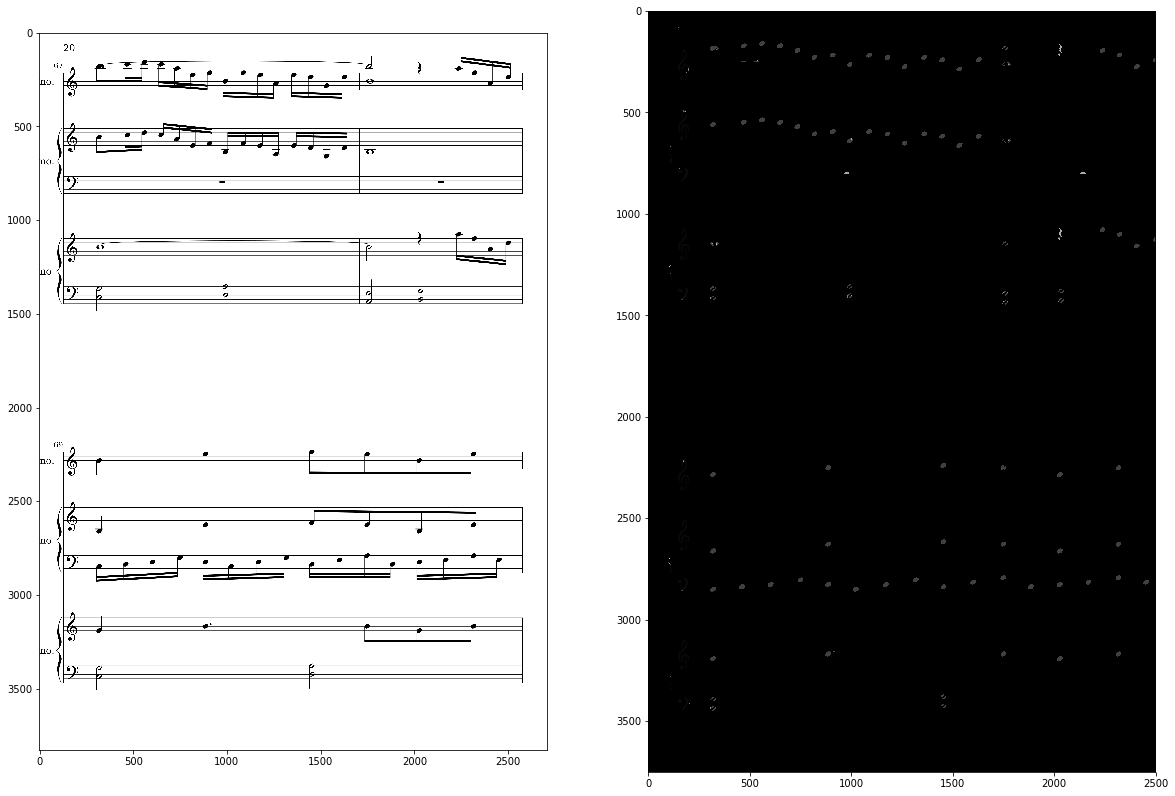

In [24]:
stitchImagePreds(path, model, model_weight_path)

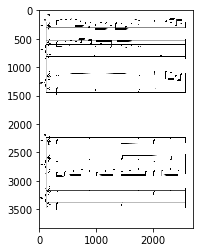

In [31]:
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

# Compare

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
img2pix = [numBlack2, numBlackSmall2, numHalf2, numHalfSmall2, numWhole2, numWholeSmall2, numDoubleWhole2, numDoubleWholeSmall2]

In [ ]:
def createNoteValueDict():
    noteValues = {}
    noteValues["noteheadBlack"] = 29
    noteValues["noteheadBlackSmall"] = 30
    noteValues["noteheadHalf"] = 31
    noteValues["noteheadHalfSmall"] = 32
    noteValues["noteheadWhole"] = 33
    noteValues["noteheadWholeSmall"] = 34
    noteValues["noteheadDoubleWhole"] = 35
    noteValues["noteheadDoubleWholeSmall"] = 36
    return noteValues

In [ ]:
def getNotes(image):
    valueDict = createNoteValueDict()
    img = Image.open(image)
    
    #create dict of values for image and set to 0
    imageValues = valueDict
    for key in imageValues.keys():
        imageValues[key] = 0
    
    for pixel in img.getdata():
        if pixel == noteheadBlack:
            imageValues["noteheadBlack"] += 1
        elif pixel == noteheadBlackSmall:
            imageValues["noteheadBlackSmall"] += 1
        elif pixel == noteheadHalf:
            imageValues["noteheadHalf"] += 1
        elif pixel == noteheadHalfSmall:
            imageValues["noteheadHalfSmall"] += 1
        elif pixel == noteheadWhole:
            imageValues["noteheadWhole"] += 1
        elif pixel == noteheadWholeSmall:
            imageValues["noteheadWholeSmall"] += 1
        elif pixel == noteheadDoubleWhole:
            imageValues["noteheadDoubleWhole"] += 1
        elif pixel == noteheadDoubleWholeSmall:
            imageValues["noteheadDoubleWholeSmall"] += 1
            
    return imageValues

In [ ]:
def naiveDistance(img_1, img_2):
    totalDist = 0
    img1_values = getNotes(img_1)
    img2_values = getNotes(img_2)
    
    for key in img1_values.keys():
        totalDist += (img1_values[key] - img2_values[key])
        
    totalDist = abs(totalDist)
        
    print("total distance between images 1 and 2: " + str(totalDist))

add stuff to go through database and get distances